In [30]:
import time
import Levenshtein
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from chembl_webresource_client.new_client import new_client

In [13]:
new_client.molecule.filter(molecule_chembl_id='CHEMBL12198').only(
    'molecule_properties')[0]['molecule_properties']

{'acd_logd': '-3.08',
 'acd_logp': '-0.57',
 'acd_most_apka': '2.31',
 'acd_most_bpka': '9.61',
 'alogp': '-0.58',
 'aromatic_rings': 0,
 'full_molformula': 'C3H7NO2',
 'full_mwt': '89.09',
 'hba': 2,
 'hba_lipinski': 3,
 'hbd': 2,
 'hbd_lipinski': 3,
 'heavy_atoms': 6,
 'molecular_species': 'ZWITTERION',
 'mw_freebase': '89.09',
 'mw_monoisotopic': '89.0477',
 'num_lipinski_ro5_violations': 0,
 'num_ro5_violations': 0,
 'psa': '63.32',
 'qed_weighted': '0.45',
 'ro3_pass': 'N',
 'rtb': 1}

In [2]:
# Key of the outer dctionary is the 1 letter identifier for each amino acid
aminoAcids = {'A':'CHEMBL12198', 'C': "CHEMBL863", 'D':'CHEMBL274323', 'E':'CHEMBL575060',
              'F':'CHEMBL301523', 'G':'CHEMBL773', 'H':'CHEMBL17962', 'I':'CHEMBL1233584',
              'K':'CHEMBL8085', 'L':'CHEMBL291962', 'M':'CHEMBL42336', 'N':'CHEMBL58832',
              'P':'CHEMBL54922', 'Q':'CHEMBL930', 'R':'CHEMBL1485', 'S':'CHEMBL11298',
              'T':'CHEMBL291747', 'V':'CHEMBL43068', 'W':'CHEMBL54976', 'Y':'CHEMBL925'}

In [3]:
# This gives the properties for the singlular amino acid
properties = dict()
for aa, cid in aminoAcids.items():
    properties[aa] = new_client.molecule.filter(molecule_chembl_id=cid).only(
        'molecule_properties')[0]['molecule_properties']

In [4]:
# Only care about the side chain properties, the differing part of the amino acid
# Values corrected for the side chain, modified mostly by glycine values
properties_side_chain = dict()
for aa in properties.keys():
    properties_side_chain[aa] = [float(properties[aa]['acd_logd']), float(properties[aa]['acd_logp']),
                                 properties[aa]['aromatic_rings'], properties[aa]['hba'] - 2,
                                 properties[aa]['hbd'] - 2, float(properties[aa]['full_mwt']) - 74.06,
                                 properties[aa]['heavy_atoms'] - 5, float(properties[aa]['psa']) - 63.32,
                                 properties[aa]['rtb'] - 1]

In [5]:
# Sequences are stored within a *.a2m file which in addition to the above codes, uses X, B, Z, and -/.
# X represents any amino acid features will be arveraged
# B represents N/D features will be averaged
# Z represents Q/E features will be averaged
# ./- represents a gap character 
items = [i for i in range(len(properties_side_chain['A']))]
properties_side_chain['X'] = [np.mean([x[i] for x in properties_side_chain.values()]) for i in items]
properties_side_chain['B'] = [np.mean([x[i] for x in [properties_side_chain['N'],
                                                     properties_side_chain['D']]]) for i in items]
properties_side_chain['Z'] = [np.mean([x[i] for x in [properties_side_chain['Q'],
                                                     properties_side_chain['E']]]) for i in items]
properties_side_chain['-'] = [0 for i in items]
properties_side_chain['.'] = [0 for i in items]

In [6]:
gal4_seqs = list()
with open('sequences/GAL4_YEAST_hmmerbit_plmc_n5_m30_f50_t0.2_r1-75_id100_b45.a2m', 'r') as f:
    for count, line in enumerate(f, start=1):
        if count % 2 == 0:
            gal4_seqs.append(line.upper().rstrip())

In [7]:
gal4_as_features = list()
for seq in gal4_seqs:
    seq_as_features = list()
    for aa in seq:
        if properties_side_chain[aa] == None:
            raise Exception(aa)
        seq_as_features.append(properties_side_chain[aa])
    gal4_as_features.append(seq_as_features)

In [8]:
# Training on 100 entries, where each entry is a the 5 properties for each  took 1.58 seconds
# Training on 1000 entries took 200 seconds
# This was the wrong way to flatten the list, svm does all AA at the same position
start_time = time.time()
svm_aa = svm.OneClassSVM()
svm_aa.fit([item for sublist in gal4_as_features[:100] for item in sublist])
print(time.time() - start_time)

/home/silvajos/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


1.573669672012329


In [47]:
gal4_as_all = list()
for seq in gal4_as_features:
    temp = list()
    for aa in seq:
        for f in aa:
            temp.append(f)
    gal4_as_all.append(temp)

In [10]:
len(gal4_as_all)

17521

In [11]:
# Each point of the svm is a single sequence, where the features are all of the amino acids
# 10,000 entries take 214 seconds
start_time = time.time()
svm0 = svm.OneClassSVM()
svm0.fit(gal4_as_all[:10000])
print(time.time() - start_time)

/home/silvajos/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


214.64266848564148


In [12]:
start_time = time.time()
x_pred = svm0.predict(gal4_as_all[10000:])
print(time.time() - start_time)

50.41265916824341


In [22]:
# It got right .76% of sequences, sum is negative
(len(x_pred) + sum(x_pred)) / 2 / len(x_pred)

0.007578779417630634

In [25]:
# Training on 10,000 examples takes 2.7 seconds
# This was the wrong way to flatten the list, svm does all AA at the same position
start_time = time.time()
svm_aa35 = svm.OneClassSVM()
svm_aa35.fit([seq[35] for seq in gal4_as_features[:10000]])
print(time.time() - start_time)

/home/silvajos/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


2.686241626739502


In [28]:
start_time = time.time()
x_pred35 = svm_aa35.predict([seq[35] for seq in gal4_as_features[10000:]])
print(time.time() - start_time)

1.283959150314331


In [31]:
# It got right 25.4% of sequences, sum is negative
(len(x_pred35) + sum(x_pred35)) / 2 / len(x_pred35)

0.25435447413907725

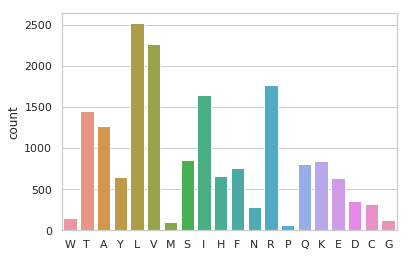

In [77]:
sns.set_style('whitegrid')
gal4_35aa = [x[35] for x in gal4_seqs]
sns.countplot(gal4_35aa)

[Text(0.5, 0, 'Amino acid present at 36 position of sequence of GAL4'),
 Text(0.5, 1.0, 'Nonrandomized amino acid distribution for first 10,000 entries')]

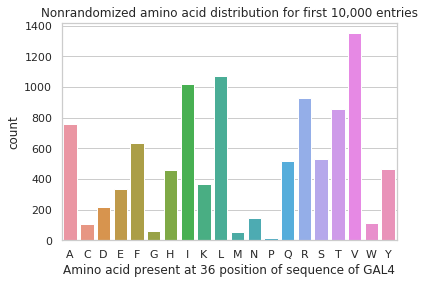

In [81]:
ax = sns.countplot(gal4_35aa[:10000], order = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M',
                                               'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])
ax.set(title ='Nonrandomized amino acid distribution for first 10,000 entries',
       xlabel='Amino acid present at 36 position of sequence of GAL4')

[Text(0.5, 0, 'Amino acid present at 36 position of sequence of GAL4'),
 Text(0.5, 1.0, 'Nonrandomized amino acid distribution for last 7,000 entries')]

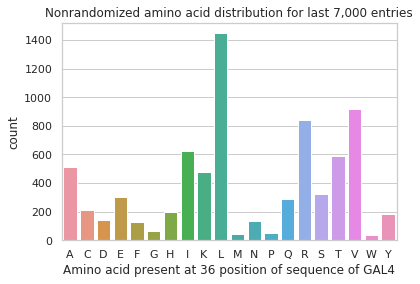

In [84]:
ax2 = sns.countplot(gal4_35aa[10000:],order = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M',
                                               'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])
ax2.set(title ='Nonrandomized amino acid distribution for last 7,000 entries',
       xlabel='Amino acid present at 36 position of sequence of GAL4')

### Need to randomize the dataframe, the sequences in the file are not randomly ordered

In [8]:
train_features, test_features = train_test_split(gal4_as_features, test_size=0.5)

In [39]:
# Training on 10,000 examples takes 2.7 seconds
# This was the wrong way to flatten the list, svm does all AA at the same position
start_time = time.time()
svm_aa35r = svm.OneClassSVM()
svm_aa35r.fit([seq[35] for seq in train_features])
print(time.time() - start_time)

/home/silvajos/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


2.1869137287139893


In [45]:
# Repeat of the 35 aa experiment with the randomized test/train
start_time = time.time()
x_pred35r = svm_aa35r.predict([seq[35] for seq in test_features])
print(time.time() - start_time)

1.3195850849151611


In [49]:
# It got right 23% of sequences, sum is negative
(len(x_pred35r) + sum(x_pred35r)) / 2 / len(x_pred35r)

0.23136628238785525

In [55]:
sum(svm_aa35r.predict([seq[35] for seq in train_features]))

-4742

In [56]:
svm_aa35r.score_samples([seq[35] for seq in test_features])

array([309.96855942, 309.96795579, 309.96794271, ..., 309.96795579,
       309.96857335, 309.96795651])

In [31]:
def seq_weight(seq):
    try:
        x = 1 / sum([Levenshtein.hamming(seq, s) / 75 < 0.2 for s in gal4_seqs])
    except:
        raise Exception(seq)
    return x

In [34]:
seq_weights = [seq_weight(s) for s in gal4_seqs]

In [36]:
# Need to recreate splits with the sequence weights
train_features, test_features, train_weight, test_weight = train_test_split(gal4_as_features,
                                                                            seq_weights, test_size=0.5)

In [42]:
# Training on 10,000 examples takes 2.7 seconds
# For the 35 amino acid with sequences weighted
start_time = time.time()
svm_aa35rw = svm.OneClassSVM()
svm_aa35rw.fit([seq[35] for seq in train_features], sample_weight=train_weight)
x_pred35rw = svm_aa35rw.predict([seq[35] for seq in test_features])
print(time.time() - start_time)

/home/silvajos/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


3.7141013145446777


In [43]:
# It got right 27% of sequences, sum is negative
(len(x_pred35rw) + sum(x_pred35rw)) / 2 / len(x_pred35rw)

0.2701746375984477

In [44]:
# Training on 10,000 examples takes 2.7 seconds
# For the 35 amino acid with sequences weighted by uniqueness
start_time = time.time()
svm_aa35rws = svm.OneClassSVM(gamma='scale')
svm_aa35rws.fit([seq[35] for seq in train_features], sample_weight=train_weight)
x_pred35rws = svm_aa35rws.predict([seq[35] for seq in test_features])
print(time.time() - stasrt_time)
print(sum(x_pred35rws))

3.318368673324585
-139


In [45]:
# Changing gamma to auto gave accuracy of 0.492
(len(x_pred35rws) + sum(x_pred35rws)) / 2 / len(x_pred35rws)

0.4920671156260701

In [48]:
# Need to recreate splits with the sequence weights this time for the all set
train_all_feat, test_all_feat, train_all_weight, test_all_weight = train_test_split(gal4_as_all,
                                                                            seq_weights, test_size=0.5)

In [49]:
# Training on 10,000 examples takes 2.7 seconds
# This was the wrong way to flatten the list, svm does all AA at the same position
start_time = time.time()
svm_allws = svm.OneClassSVM(gamma='scale')
svm_allws.fit(train_all_feat, sample_weight=train_all_weight)
x_predallws = svm_allws.predict(test_all_feat)
print(time.time() - start_time)
print(sum(x_predallws))

134.78308534622192
-139


In [51]:
# 0.12 accuracy when all amino acids in a sequence are given at once
(len(x_predallws) + sum(x_predallws)) / 2 / len(x_predallws)

0.12053418559525168

In [76]:
# Running the svm on each of the amino acid positions
start_time = time.time()
aa_predictions = list()
aa_score = list()
aa_train_score = list()
for i in range(len(gal4_seqs[0])):
    svm_aa = svm.OneClassSVM(gamma='scale')
    svm_aa.fit([seq[i] for seq in train_features], sample_weight=train_weight)
    aa_predictions.append(svm_aa.predict([seq[i] for seq in test_features]))
    aa_score.append(svm_aa.score_samples([seq[i] for seq in test_features]))
    aa_train_score.append(svm_aa.score_samples([seq[i] for seq in train_features]))
    if i % 10 == 0:
        print("finished with ", i)
print(time.time() - start_time)

finished with  0
finished with  10
finished with  20
finished with  30
finished with  40
finished with  50
finished with  60
finished with  70
496.70160269737244


In [70]:
pct_correct = [(len(x) + (-1 if sum(x) > 0 else 1) * sum(x)) / 2 / len(x) for x in aa_predictions]

[Text(0, 0.5, 'recall'),
 Text(0.5, 0, 'position in sequence'),
 Text(0.5, 1.0, 'Recall of model for amino acids of the GAL4 sequence')]

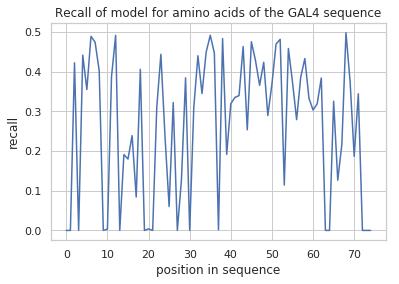

In [85]:
ax = sns.lineplot(x=range(75), y=pct_correct)
ax.set(title = 'Recall of model for amino acids of the GAL4 sequence', ylabel = 'recall',
       xlabel='position in sequence')